<a href="https://colab.research.google.com/github/KKothadia/Flight_Delay_Analysis/blob/main/src/SummativeAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are developing an AI model that can predict the flight delays during the flight duration based on data about previous delay/turbulence encountered.


To do that we will follow a few simple steps:

1. first we will import all the necessary libraries and datasets, and then select variables for trend analysation and prediction in flight delays.

2. We will process and clean all our data to eliminate null values as well as make sure all the outputs are in appropriate datatype.

3. We will finally do an explonatory analysis to analyse delay trends and patterns.

In [ ]:
#Installing necessary libraries
!pip install catboost

In [ ]:
#Importing Necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

After importing the necessary libraries we will import the datasets

In [ ]:
file_path = 'data/feb-20-us-flight-delay.csv'
data = pd.read_csv(file_path)

The data has been obtained from the US Bureau of Transportation Statistics through kaggle, lets take a look.

After carefully analyzing each data points, we have decided to manually pick 9 variable to predict if there will be a delay in the flight.

MONTH - Month

DAY_OF_MONTH - Day of Month

DAY_OF_WEEK - Day of Week

OP_UNIQUE_CARRIER - Unique Carrier Code
ORIGIN - Origin airport location

DEST - Destination airport location
DEP_TIME - Actual Departure Time (local time)

DEP_DEL15 - Departure Delay Indicator, 15 Minutes or More (1=Yes, 0=No) [TARGET VARIABLE]

DISTANCE - Distance between airports (miles)


In [ ]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DISTANCE,Unnamed: 9
0,2,1,6,MQ,CLT,LYH,1430.0,0.0,175.0,NaN
1,2,8,6,MQ,CLT,LYH,1442.0,0.0,175.0,NaN
2,2,13,4,MQ,DFW,SHV,2247.0,0.0,190.0,NaN
3,2,14,5,MQ,DFW,SHV,2230.0,0.0,190.0,NaN
4,2,15,6,MQ,DFW,SHV,2246.0,0.0,190.0,NaN


# DATA PREPROCESSING

first, we will get rid of the extra column in our dataset (if there are any)

In [ ]:
data = data.drop(['Unnamed: 9'], axis=1)

Finding the distribution of our taregt variable

In [ ]:
data['DEP_DEL15'].value_counts()

,count
DEP_DEL15,
0.0,487135
1.0,82182


We have a highly imbalanced data, because there are only 14.43% rows with delays (value of 1.0)

We will drop the rows with no delays in flight

In [ ]:
# Split the data into positive and negative
positive_rows = data.DEP_DEL15 == 1.0
data_pos = data.loc[positive_rows]
data_neg = data.loc[~positive_rows]

# Merge the balanced data
data = pd.concat([data_pos, data_neg.sample(n = len(data_pos))], axis = 0)

# Shuffle the order of data
data = data.sample(n = len(data)).reset_index(drop = True)

Removing all the null values, if there are any present

In [ ]:
data.isna().sum()

,0
MONTH,0
DAY_OF_MONTH,0
DAY_OF_WEEK,0
OP_UNIQUE_CARRIER,0
ORIGIN,0
DEST,0
DEP_TIME,844
DEP_DEL15,847
DISTANCE,0


In [ ]:
data = data.dropna(axis=0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163517 entries, 0 to 164363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              163517 non-null  int64  
 1   DAY_OF_MONTH       163517 non-null  int64  
 2   DAY_OF_WEEK        163517 non-null  int64  
 3   OP_UNIQUE_CARRIER  163517 non-null  object 
 4   ORIGIN             163517 non-null  object 
 5   DEST               163517 non-null  object 
 6   DEP_TIME           163517 non-null  float64
 7   DEP_DEL15          163517 non-null  float64
 8   DISTANCE           163517 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 12.5+ MB


We see that our target variable DEP_DEL15 has the datatype of float64.

converting it to *int*

In [ ]:
data['DEP_DEL15'] = data['DEP_DEL15'].astype(int)

Having a look at the number of columns and rows in our dataset

In [ ]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns in our dataset.")

There are 163517 rows and 9 columns in our dataset.


# Exploratory Data Analysis

Finding meaningful insights out of our dataset

In [ ]:
data.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DEL15,DISTANCE
count,163517.0,163517.000000,163517.000000,163517.000000,163517.000000,163517.000000
mean,2.0,14.813169,4.018958,1416.927188,0.502590,792.802718
std,0.0,8.180448,1.919449,498.317890,0.499995,576.068380
min,2.0,1.000000,1.000000,1.000000,0.000000,31.000000
25%,2.0,7.000000,2.000000,1026.000000,0.000000,369.000000
50%,2.0,14.000000,4.000000,1437.000000,1.000000,644.000000
75%,2.0,22.000000,6.000000,1827.000000,1.000000,1034.000000
max,2.0,29.000000,7.000000,2400.000000,1.000000,5095.000000


Apart from the statistics given in the table above, we observe that there are 6 numerical and 3 categorical variables present in our dataset.

Let's visualize the distribution of DISTANCE variable

<ipython-input-14-c33ecb791f8b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['DISTANCE'], hist=False, color="b", kde_kws={"shade": True})


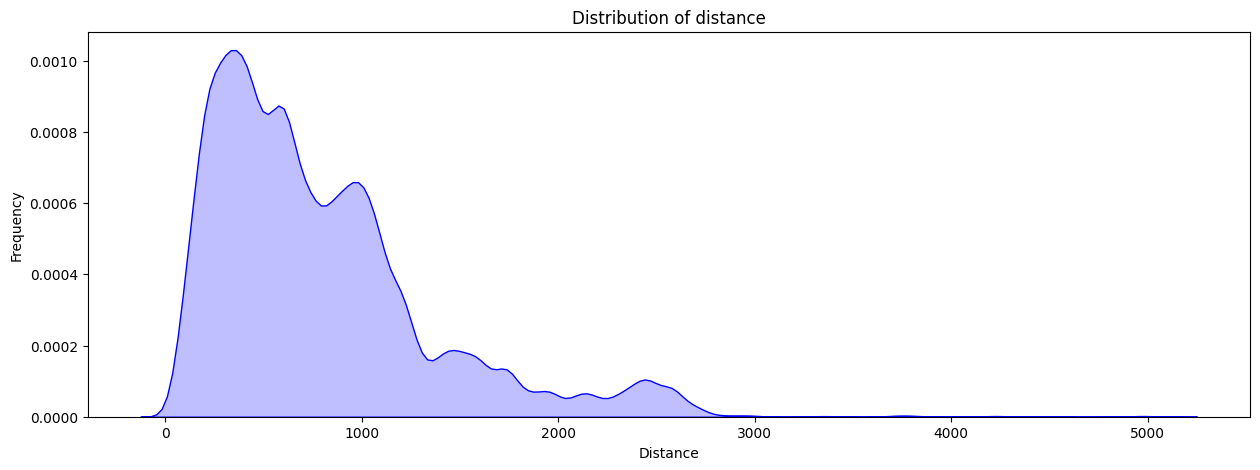

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(data['DISTANCE'], hist=False, color="b", kde_kws={"shade": True})
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of distance")
plt.show()

We can see that our DISTANCE variable is positively skewed. Lets find out the correlation between the distance and delay of a flight.

Though, there is no possible way to find correlation between a continuous and categorical variable, I'll try to find the average distance for DEP_DEL15 variable.



In [ ]:
print(f"Average distance if there is a delay {data[data['DEP_DEL15'] == 1]['DISTANCE'].values.mean()} miles")
print(f"Average distance if there is no delay {data[data['DEP_DEL15'] == 0]['DISTANCE'].values.mean()} miles")

Average distance if there is a delay 786.1071280815751 miles
Average distance if there is no delay 799.5680334419377 miles


Visualising Categorical variables

here we are counting the carriers in the dataset

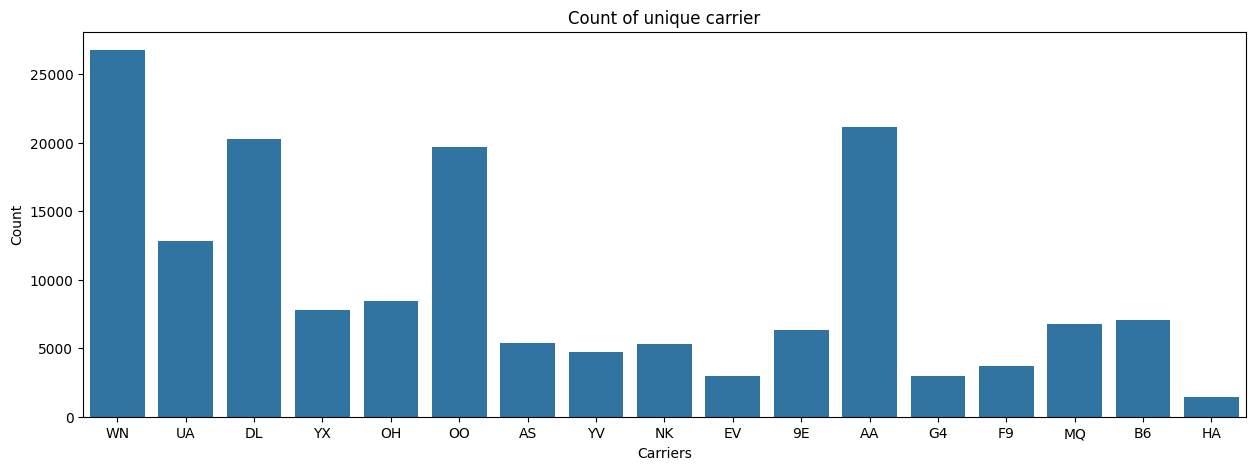

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x=data['OP_UNIQUE_CARRIER'], data=data)
plt.xlabel("Carriers")
plt.ylabel("Count")
plt.title("Count of unique carrier")
plt.show()

Count of origin and destination airport

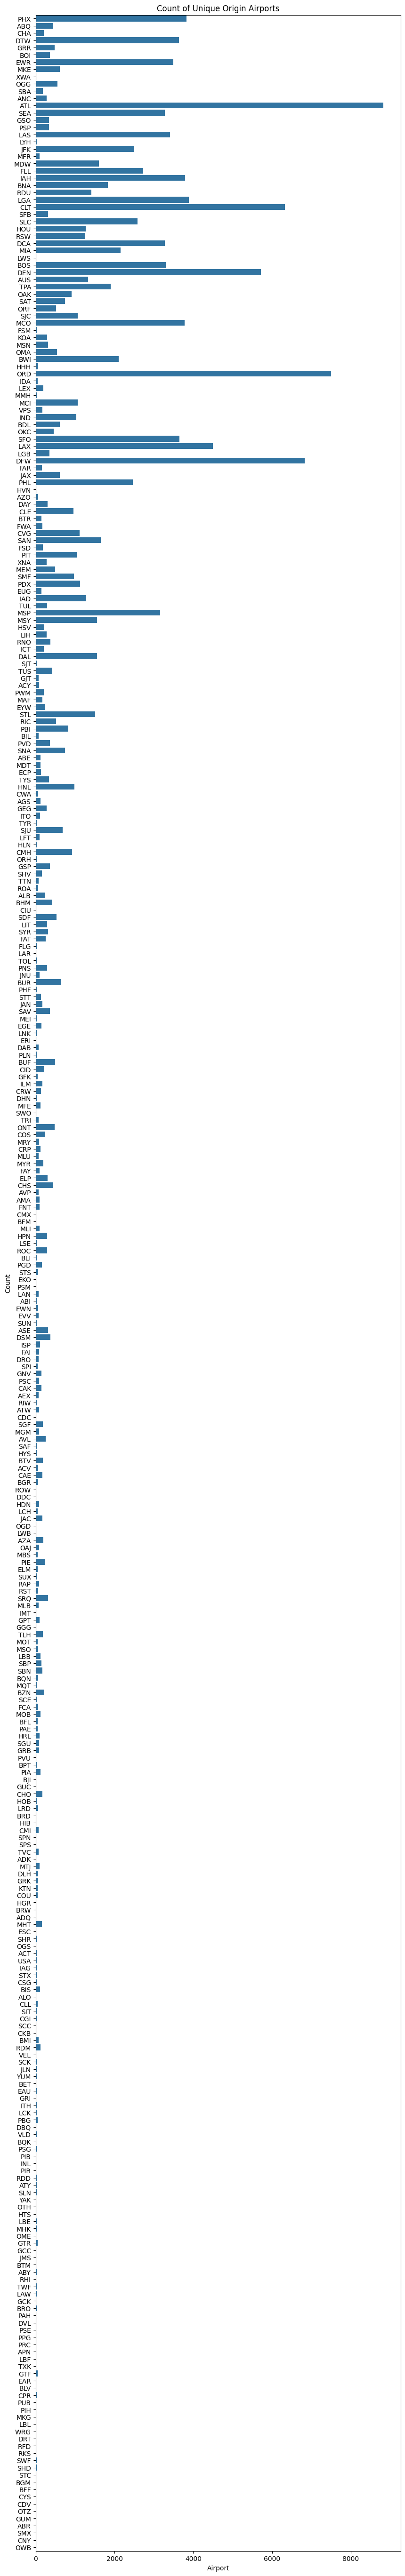

In [ ]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['ORIGIN'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Origin Airports")
plt.show()

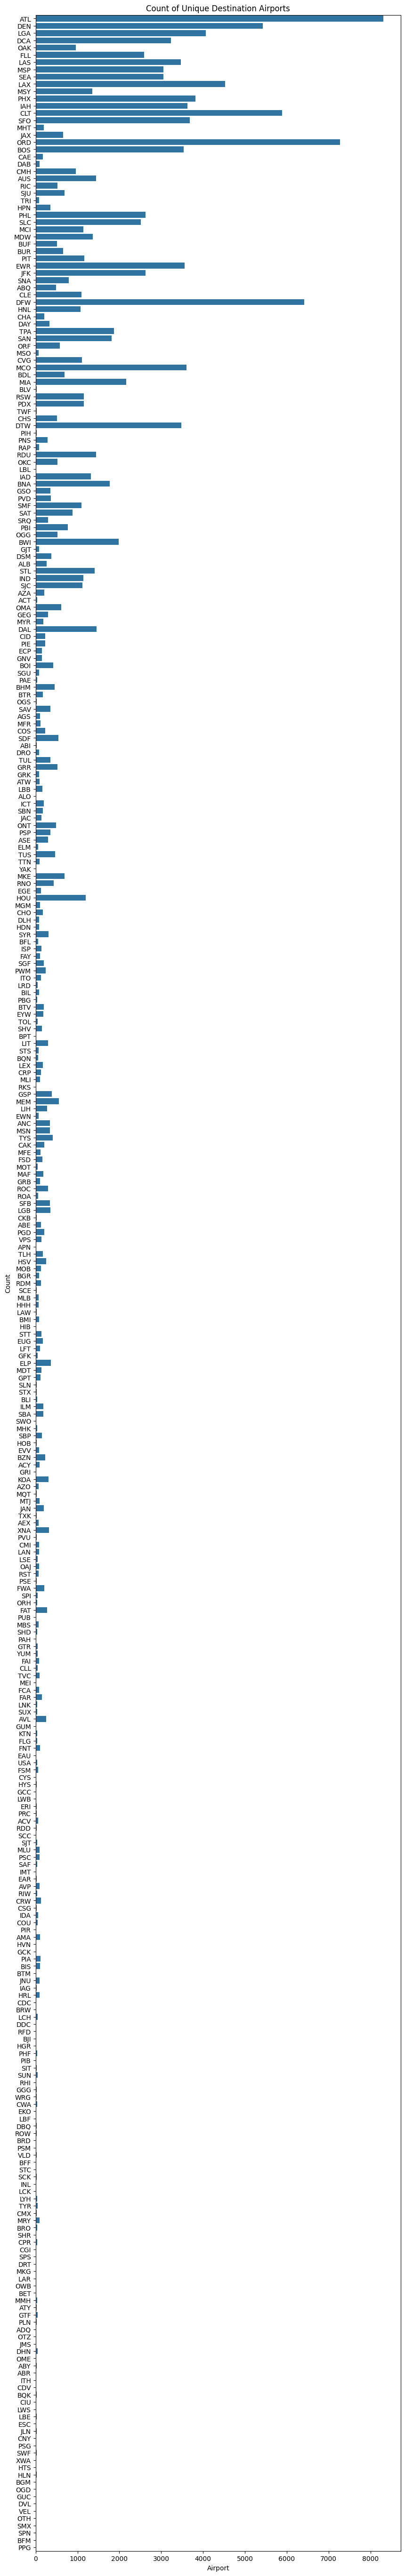

In [ ]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['DEST'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Destination Airports")
plt.show()